# NLP of SEG Geophysics journal - part2: data analysis

In this second notebook, the data extracted from the digital library of Geophysics journal will be loaded and analysed using basic Natural Language Processing and statistical analysis.

Once a group of volumes is selected and information previously saved are reload into memory, I will try to answer the following questions for a single volume, a bunch of volumes 

- What is the most used word in titles?
- What is the most prolific author?
- What is the most prolific country and institution?
- What is the average (and higher order stats) for turnaround time of a paper (From the day the paper is received until is accepted and published)
- What's the percentage of male and female authors?

And finally, I will try to do some machine learning using supervised learning with NLP:
- Is it  possible to identify the category of a paper given the words in its title (using bag-of-words approach). I will split my titles into two sets, try to train a model based on the first set and predict on the other one.

In [1]:
import os
import glob 
from datetime import datetime,date
import random
import itertools
import pickle
import time

import requests
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import names
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics

from IPython.display import display

from utils import *

# Figures inline and set visualization style
%matplotlib inline
sns.set()
sns.set_style("whitegrid")

Let's start by setting the path where data have been saved in previous notebook

In [2]:
pathSEG='../SEG_Geophysics/'

First of all I choose which volumes I want to extract statistics from. Here we can just write a list of volumes of use UNIX wildcards.

**Note: to be able to reproduce the results that are shown in the README file, the last 5 years (until 2012 included) have to be loaded** 

In [3]:
#selvolumes = ['*']
selvolumes = ['8*','79','78','77']

Let's then reload the information saved in previous notebook

In [4]:
dirissues = [glob.glob(pathSEG+selvolume+'/') for selvolume in selvolumes]
dirissues = list(itertools.chain(*dirissues))
dirissues = [glob.glob(dirissue+'/*/') for dirissue in dirissues]
dirissues = [issue for sublist in dirissues for issue in sublist]


words_titles    = []
words_abstracts = []
authors         = []
countries       = []
affiliations    = []


for dirissue in dirissues:
    print('Retrieve info from %s' % dirissue)
    with open(dirissue+'wordstitle_SEG', 'rb') as ft,\
         open(dirissue+'authors_SEG', 'rb') as fa,\
         open(dirissue+'countries_SEG', 'rb') as fc,\
        open(dirissue+'affiliations_SEG', 'rb') as fi:
        
        words_title = pickle.load(ft)
        words_titles.extend(words_title)

        author = pickle.load(fa)
        authors.extend(author)
        
        country = pickle.load(fc)
        countries.extend(country)
        
        affiliation = pickle.load(fi)
        affiliations.extend(affiliation)

Retrieve info from ../SEG_Geophysics/80/1/
Retrieve info from ../SEG_Geophysics/80/2/
Retrieve info from ../SEG_Geophysics/80/3/
Retrieve info from ../SEG_Geophysics/80/4/
Retrieve info from ../SEG_Geophysics/80/5/
Retrieve info from ../SEG_Geophysics/80/6/
Retrieve info from ../SEG_Geophysics/81/1/
Retrieve info from ../SEG_Geophysics/81/2/
Retrieve info from ../SEG_Geophysics/81/3/
Retrieve info from ../SEG_Geophysics/81/4/
Retrieve info from ../SEG_Geophysics/81/5/
Retrieve info from ../SEG_Geophysics/81/6/
Retrieve info from ../SEG_Geophysics/82/1/
Retrieve info from ../SEG_Geophysics/82/2/
Retrieve info from ../SEG_Geophysics/82/3/
Retrieve info from ../SEG_Geophysics/82/4/
Retrieve info from ../SEG_Geophysics/82/5/
Retrieve info from ../SEG_Geophysics/79/1/
Retrieve info from ../SEG_Geophysics/79/2/
Retrieve info from ../SEG_Geophysics/79/3/
Retrieve info from ../SEG_Geophysics/79/4/
Retrieve info from ../SEG_Geophysics/79/5/
Retrieve info from ../SEG_Geophysics/79/6/
Retrieve in

Reload tables and concatenate them into unique one

In [5]:
df_seg    = pd.DataFrame()
for dirissue in dirissues:
    df_seg = df_seg.append(pd.read_csv(dirissue+'/df_SEG.csv',index_col=0), ignore_index=True)

df_seg = df_seg[['Title', 'Authors', 'Category', 'Volume', 'Issue', 'Countries', 'Affiliations', 
                 'Keywords', 'Ncitations', 'Received', 'Accepted', 'Published']]
df_seg = df_seg.dropna(axis=0, how='any').reset_index(drop=True)

display(df_seg)

,Title,Authors,Category,Volume,Issue,Countries,Affiliations,Keywords,Ncitations,Received,Accepted,Published
0,Regional seismicity: A potential pitfall for i...,Enrico Caffagni; David Eaton; Mirko van der Ba...,Geophysics Letters,80,1,Canada; Canada,University of Calgary; University of Alberta,Passive seismic; LPLD events; earthquakes,9,2014-08-14,2014-10-06,2014-12-22
1,Internal multiple prediction and removal using...,Giovanni Angelo Meles; Katrin Löer; Matteo Rav...,Geophysics Letters,80,1,UK,The University of Edinburgh,multiples; reflection; adaptive subtraction,17,2014-08-26,2014-10-06,2014-12-24
2,Eliminating the azimuth ambiguity in single-we...,Hao Gong; Hao Chen; Xiao He; Xiuming Wang,Geophysics Letters,80,1,China,Chinese Academy of Sciences,acoustic; borehole geophysics; multicomponent;...,6,2014-07-23,2014-10-15,2014-12-24
3,A robust experimental determination of Thomsen...,Joel Sarout; Claudio Delle Piane; Dariush Nadr...,Geophysics Letters,80,1,Australia,CSIRO Energy,anisotropy; rock physics; P-wave; shear wave (...,9,2014-08-18,2014-10-11,2014-12-30
4,Electrical resistivity imaging for long-term a...,Jeffrey Heenan; Lee D. Slater; Dimitrios Ntarl...,Case Histories,80,1,USA; USA; USA; USA,Rutgers University; Oklahoma State University;...,resistivity; time-lapse; near surface,6,2013-12-16,2014-09-28,2014-12-22
5,Shear-wave group-velocity surfaces in low-symm...,Vladimir Grechka,Anisotropy,80,1,USA,Marathon Oil Company,anisotropy; microseismic; shear wave (S-wave),18,2014-04-05,2014-09-12,2014-12-01
6,Linking preferred orientations to elastic anis...,Waruntorn Kanitpanyacharoen; Roman Vasin; Hans...,Anisotropy,80,1,USA; Thailand; USA; Russia; USA; Australia,University of California; Chulalongkorn Univer...,Shale; Anisotropy; Clay minerals; Preferred or...,5,2014-05-19,2014-10-20,2014-12-30
7,Azimuthal amplitude variation with offset anal...,Faranak Mahmoudian; Gary F. Margrave; Joe Wong...,Anisotropy,80,1,Canada; Canada,Shell Canada Limited; University of Calgary,amplitude variation with offset (AVO); anisotr...,6,2014-02-09,2014-09-23,2014-12-31
8,Prediction of sonic velocities in shale from p...,Marina Pervukhina; Pavel Golodoniuc; Boris Gur...,Borehole Geophysics and Rock Properties,80,1,Australia; Australia; Australia; Australia; Au...,CSIRO Energy; CSIRO Mineral Resourses; Curtin ...,log analysis; rock physics; shear wave (S-wave...,4,2014-01-28,2014-08-31,2014-12-01
9,Determination of nuclear magnetic resonance T2...,Xinmin Ge; Yiren Fan; Xuejuan Zhu; Yiguo Chen;...,Borehole Geophysics and Rock Properties,80,1,China; China; China; China,China University of Petroleum (Huadong); China...,signal processing; log analysis; rock physics,10,2014-03-24,2014-08-26,2014-12-04


## NLP

### Word count plots

Create a frequency distribution plot of most used words in titles

Most used words in title: [(u'data', 418), (u'seismic', 392), (u'inversion', 332), (u'using', 323), (u'time', 244)]


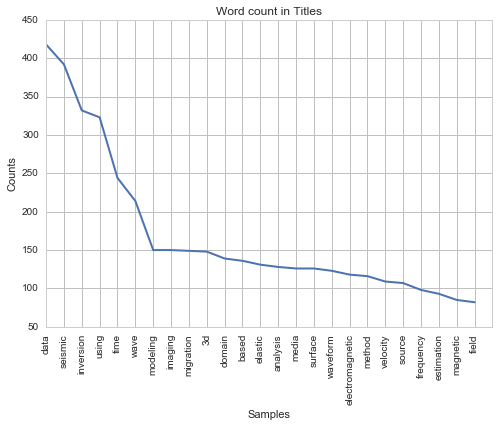

In [6]:
freqdist_words = nltk.FreqDist(words_titles)
print('Most used words in title: %s' % freqdist_words.most_common(5))
freqdist_words.plot(25, title='Word count in Titles')

Create a wordcloud plot of most used words in titles

(-0.5, 399.5, 199.5, -0.5)

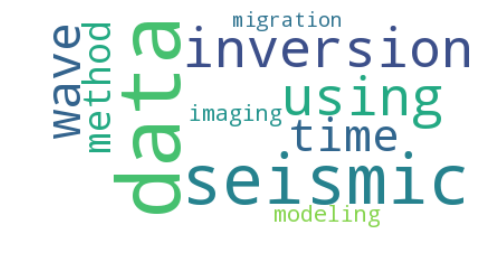

In [7]:
wordcloud = WordCloud(max_words=10,collocations=False,background_color='white').generate(' '.join(words_titles))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

Create a frequency distribution plot of most prolific authors

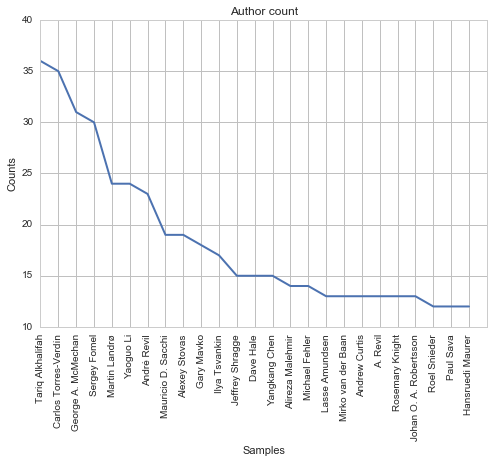

In [8]:
freqdist_authors = nltk.FreqDist(authors)
freqdist_authors.plot(25, title='Author count')

Create a frequency distribution plot of most present countries in authors affiliations

[(u'USA', 1448), (u'China', 589), (u'Canada', 300), (u'Norway', 268), (u'France', 220)]


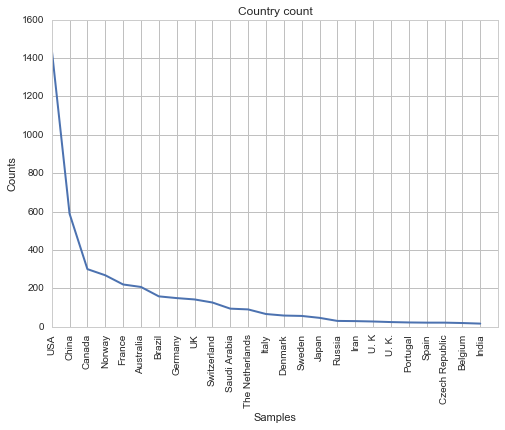

{u'Canada': 0.2063273727647868, u'Brazil': 0.10866574965612105, u'Australia': 0.14580467675378267, u'USA': 1.0, u'France': 0.15130674002751032, u'China': 0.40715268225584594, u'UK': 0.09834938101788171, u'Switzerland': 0.0873452544704264, u'Germany': 0.10247592847317744, u'Norway': 0.1843191196698762}


(-0.5, 399.5, 199.5, -0.5)

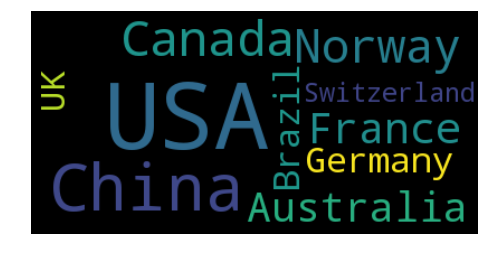

In [9]:
freqdist_countries = nltk.FreqDist(countries)
print freqdist_countries.most_common(5)
freqdist_countries.plot(25, title='Country count')

wordcloud = WordCloud(max_words=10,collocations=False).generate('\n'.join(countries))
print wordcloud.words_
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

Create a frequency distribution plot of most present insitute in authors affiliations

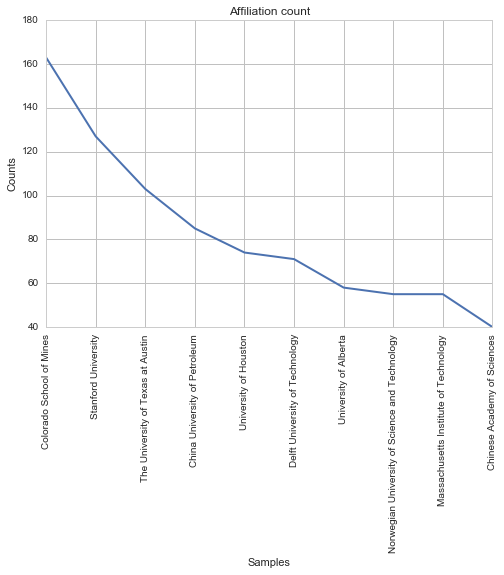

{u'Colorado_School_of_Mines': 1.0, u'Schlumberger': 0.39634146341463417, u'University_of_Houston': 0.45121951219512196, u'Stanford_University': 0.7804878048780488, u'Delft_University_of_Technology': 0.4329268292682927, u'The_University_of_Texas_at_Austin': 0.6402439024390244, u'University_of_Alberta': 0.3597560975609756, u'amp': 0.6280487804878049, u'China_University_of_Petroleum': 0.5426829268292683, u'Norwegian_University_of_Science_and_Technology': 0.34146341463414637}


(-0.5, 399.5, 199.5, -0.5)

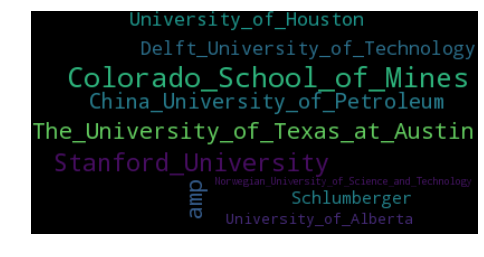

In [10]:
freqdist_institute = nltk.FreqDist(affiliations)
freqdist_institute.plot(10, title='Affiliation count')

affiliations_ = map(lambda x: x.replace(' ','_'), affiliations)
wordcloud = WordCloud(max_words=10,collocations=False).generate('\n'.join(affiliations_))
print wordcloud.words_
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

Let's see what the most prolific author produces

Most prolific author: Tariq Alkhalifah 
Number of papers: 36
Most prolific author most used keywords: [('anisotropy', 21), ('wave', 15), ('inversion', 12), ('traveltime', 11), ('migration', 10)]


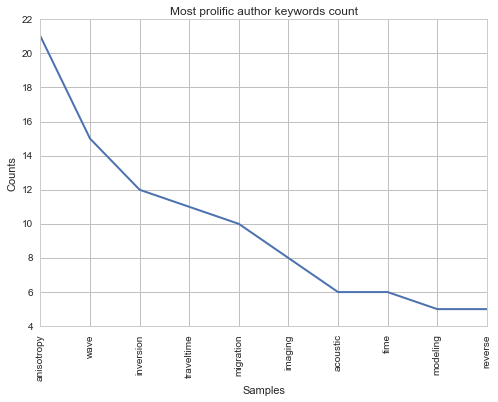

In [11]:
most_prolific_author          = (freqdist_authors.most_common(1)[0][0]).encode('utf8')
most_prolific_author_npapers  = df_seg['Authors'].str.contains(most_prolific_author).sum()
most_prolific_author_keywords = df_seg.loc[df_seg['Authors'].str.contains(most_prolific_author)==True,['Keywords']]
most_prolific_author_keywords = [most_prolific_author_keywords.iloc[i].values[0] for i in range(len(most_prolific_author_keywords))]

print('Most prolific author: %s \nNumber of papers: %d' % (most_prolific_author, most_prolific_author_npapers))
#display(df_seg.loc[df_seg['Authors'].str.contains(most_prolific_author)==True,['Title','Authors','Keywords']])

most_prolific_author_keywords = words_from_text(most_prolific_author_keywords)
freqdist_mostprolific = nltk.FreqDist(most_prolific_author_keywords)
print('Most prolific author most used keywords: %s' % freqdist_mostprolific.most_common(5))
freqdist_mostprolific.plot(10, title='Most prolific author keywords count')

### Turnaround time statistics

Let's see how long it takes to get your paper accepted in Geophysics journal

count    1867.000000
mean      210.845742
std        93.067717
min         2.000000
25%       146.000000
50%       198.000000
75%       263.000000
max       763.000000
Name: Turnaround, dtype: float64

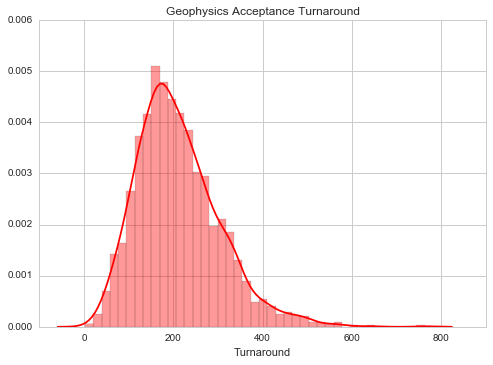

In [12]:
# Accepted 
df_seg['Turnaround'] = pd.to_datetime(df_seg['Accepted']) - pd.to_datetime(df_seg['Received'])
df_seg = df_seg[df_seg['Turnaround']>pd.Timedelta(days=0)] # remove rows with 0 days of Turnaround (they contain errata, intro to special sections...)
df_seg = df_seg[df_seg['Turnaround']<pd.Timedelta(days=10000)] # remove rows with more than 1000 days of Turnaround (for those papers where date was not present and set to default...)


df_seg['Turnaround'] = df_seg['Turnaround']/ pd.Timedelta(days=1)

display(df_seg['Turnaround'].describe())

ax = sns.distplot(df_seg['Turnaround'], color='r')
ax.set_title('Geophysics Acceptance Turnaround')

And what about the shortest and longest turnaround?

In [13]:
print('Shortest turnaround:\n\n%s' % df_seg.loc[df_seg['Turnaround'].argmin()])
print('Longest turnaround:\n\n%s' % df_seg.loc[df_seg['Turnaround'].argmax()])

Shortest turnaround:

Title                       A micro ocean-bottom E-field receiver
Authors            Kai Chen; Ming Deng; Xianhu Luo; Zhongliang Wu
Category                   Electrical and Electromagnetic Methods
Volume                                                         82
Issue                                                           5
Countries                                            China; China
Affiliations    China University of Geosciences (Beijing); Gua...
Keywords        electromagnetics; hydrates; acquisition; magne...
Ncitations                                                      0
Received                                               2016-05-10
Accepted                                               2016-05-12
Published                                              2017-07-05
Turnaround                                                      2
Name: 962, dtype: object
Longest turnaround:

Title           New full-wave phase-shift approach to solve th...
Authors 

Let's repeat the same for each issue and see if we observe some variations. Not so much variation but definitely a slower pace in issue 1

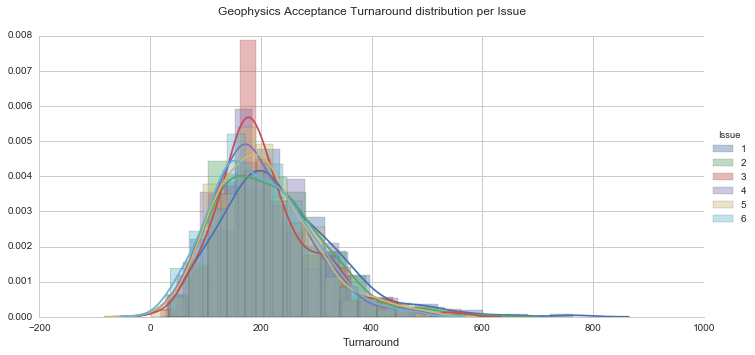

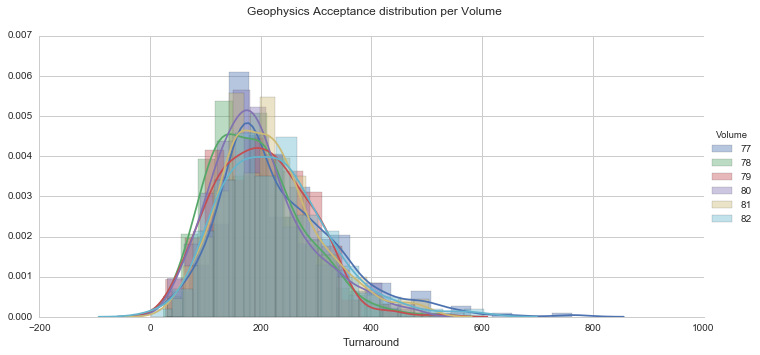

In [14]:
g = sns.FacetGrid(df_seg, hue='Issue', size=5, aspect=2)
g.map(sns.distplot, 'Turnaround', label='Key')
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Geophysics Acceptance Turnaround distribution per Issue') 

g = sns.FacetGrid(df_seg, hue='Volume', size=5, aspect=2)
g.map(sns.distplot, 'Turnaround', label='Key')
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Geophysics Acceptance distribution per Volume') 

A how long does Geophysics takes to process an accepted paper and publish it

/Users/matteoravasi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


count    1780.000000
mean       85.241011
std        32.815234
min         2.000000
25%        67.000000
50%        81.000000
75%        97.000000
max       561.000000
Name: Turnaround Publication, dtype: float64

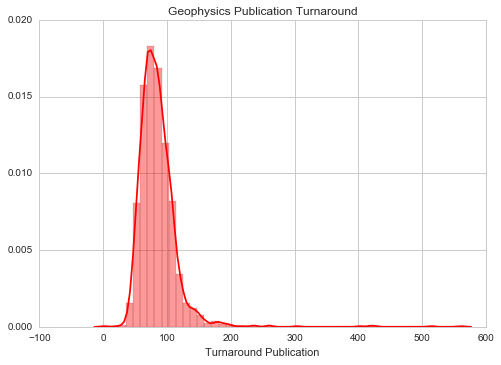

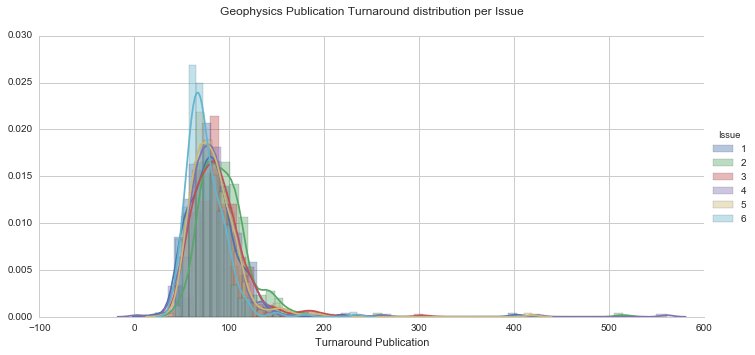

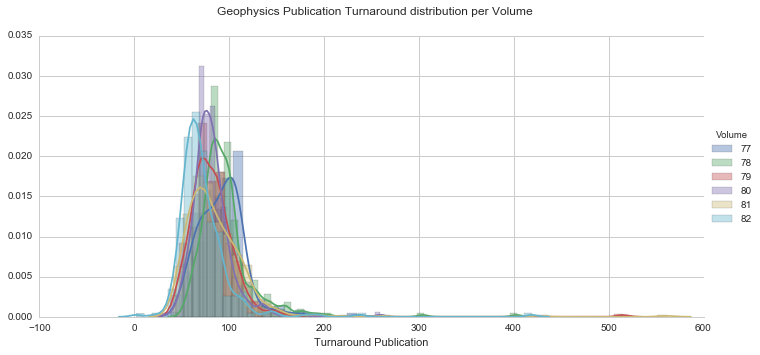

In [15]:
# Accepted 
df_seg['Turnaround Publication'] = pd.to_datetime(df_seg['Published']) - pd.to_datetime(df_seg['Accepted'])
df_seg = df_seg[df_seg['Turnaround Publication']>pd.Timedelta(days=0)] # remove rows with 0 days of Turnaround (they contain errata, intro to special sections...)
df_seg['Turnaround Publication'] = df_seg['Turnaround Publication']/ pd.Timedelta(days=1)

display(df_seg['Turnaround Publication'].describe())

ax = sns.distplot(df_seg['Turnaround Publication'], color='r')
ax.set_title('Geophysics Publication Turnaround')

g = sns.FacetGrid(df_seg, hue='Issue', size=5, aspect=2)
g.map(sns.distplot, 'Turnaround Publication', label='Key')
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Geophysics Publication Turnaround distribution per Issue') 

g = sns.FacetGrid(df_seg, hue='Volume', size=5, aspect=2)
g.map(sns.distplot, 'Turnaround Publication', label='Key')
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Geophysics Publication Turnaround distribution per Volume')

### Citations

Finally let's look into some statistics related to citations

count    1780.000000
mean        7.782022
std        11.542609
min         0.000000
25%         1.000000
50%         4.000000
75%        10.000000
max       121.000000
Name: Ncitations, dtype: float64

Max citations:

Title                                Anisotropic 3D full-waveform inversion
Authors                   Michael Warner; Andrew Ratcliffe; Tenice Nango...
Category                                                  Seismic Inversion
Volume                                                                   78
Issue                                                                     2
Countries                                                U. K; U. K; Norway
Affiliations              Imperial College London; CGGVeritas Services (...
Keywords                     inversion; 3D; anisotropy; imaging; tomography
Ncitations                                                              121
Received                                                         2012-08-20
Accepted                                                         2012-11-26
Published                                                        2013-03-01
Turnaround                                                              

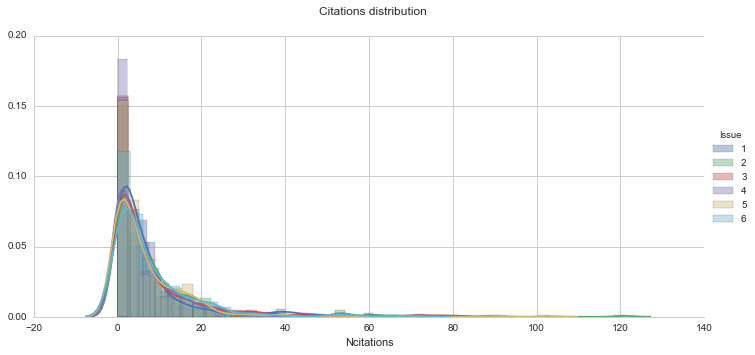

In [16]:
display(df_seg['Ncitations'].describe())
#print('Min citations:\n\n%s' % df_seg.loc[df_seg['Ncitations'].argmin()])
print('Max citations:\n\n%s' % df_seg.loc[df_seg['Ncitations'].argmax()])

g = sns.FacetGrid(df_seg, hue='Issue', size=5, aspect=2)
g.map(sns.distplot, 'Ncitations', label='Key')
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Citations distribution') 

Any correlation between turnaround time and number of present citations? Doesn't seem like...

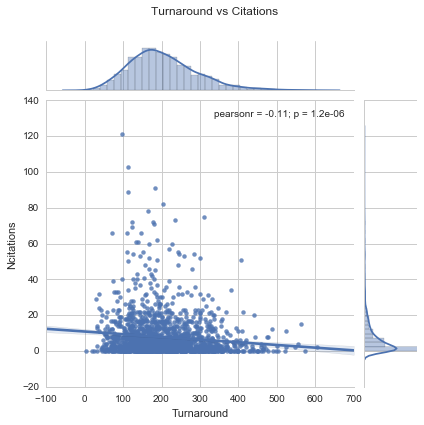

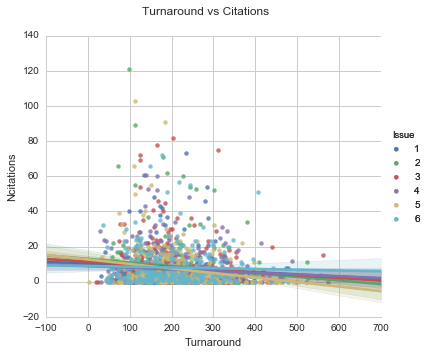

In [17]:
g = sns.jointplot("Turnaround", "Ncitations", data=df_seg, kind="reg")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Turnaround vs Citations')

g = sns.lmplot(x="Turnaround", y="Ncitations", hue="Issue", data=df_seg)
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Turnaround vs Citations') 

### Gender

Let's see if we can add a column with the Gender of the first Author of each paper and do some statistics.

To do so I will use some gender classifier that uses nltk.NaiveBayesClassifier found online at https://gist.github.com/vinovator/6e5bf1e1bc61687a1e809780c30d6bf6

In [18]:
classifier = gender_training(verb=True)

# Test out the classifier with few samples outside of training set
print('matteo: %s' % gender_classifier('matteo', classifier))
print('claire: %s' % gender_classifier('claire', classifier))

Accuracy: 0.778000 
Most Informative Features
             last_letter = u'a'           female : male   =     36.9 : 1.0
             last_letter = u'k'             male : female =     31.8 : 1.0
             last_letter = u'f'             male : female =     16.6 : 1.0
             last_letter = u'p'             male : female =     11.9 : 1.0
             last_letter = u'v'             male : female =     11.2 : 1.0
None
matteo: male
claire: female


('Male to Female ratio:', 1.9324546952224053)


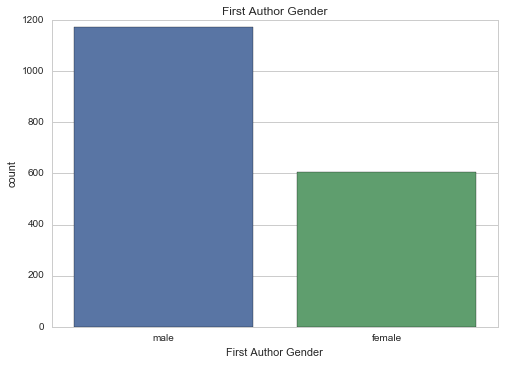

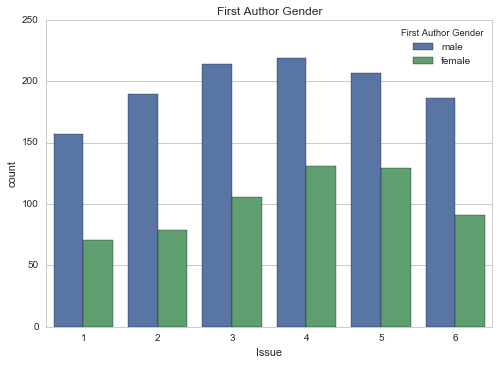

In [19]:
df_seg['First Author Name']   = df_seg['Authors'].apply(extract_first_authors_name)
df_seg['First Author Gender'] = df_seg['First Author Name'].apply(gender_classifier, classifier=classifier)

print('Male to Female ratio:', float(sum(df_seg['First Author Gender']=='male'))/
      float(sum(df_seg['First Author Gender']=='female')))

plt.figure()
ax = sns.countplot(x="First Author Gender", data=df_seg)
ax.set_title('First Author Gender')

plt.figure()
ax = sns.countplot( x="Issue", hue="First Author Gender", data=df_seg)
ax.set_title('First Author Gender')

## Classification

Finally let's try to predict the paper category from words in its title.

First, we need to bring all categories to small letters

In [20]:
df_seg['Category'] = df_seg['Category'].str.lower()

We need to remove some categories that aren't really a topic like Geophysics letters or Case Histories

In [21]:
df_seg =  (df_seg[df_seg['Category']!='Geophysics Letters']).reset_index(drop=True)
df_seg =  (df_seg[df_seg['Category']!='Case Histories']).reset_index(drop=True)
df_seg =  (df_seg[df_seg['Category']!='Errata']).reset_index(drop=True)

df_seg =  (df_seg[df_seg['Category'].str.contains('Tutorial')==False]).reset_index(drop=True)
df_seg =  (df_seg[df_seg['Category'].str.contains('Special section')==False]).reset_index(drop=True)

First let's look at the distribution of the categories

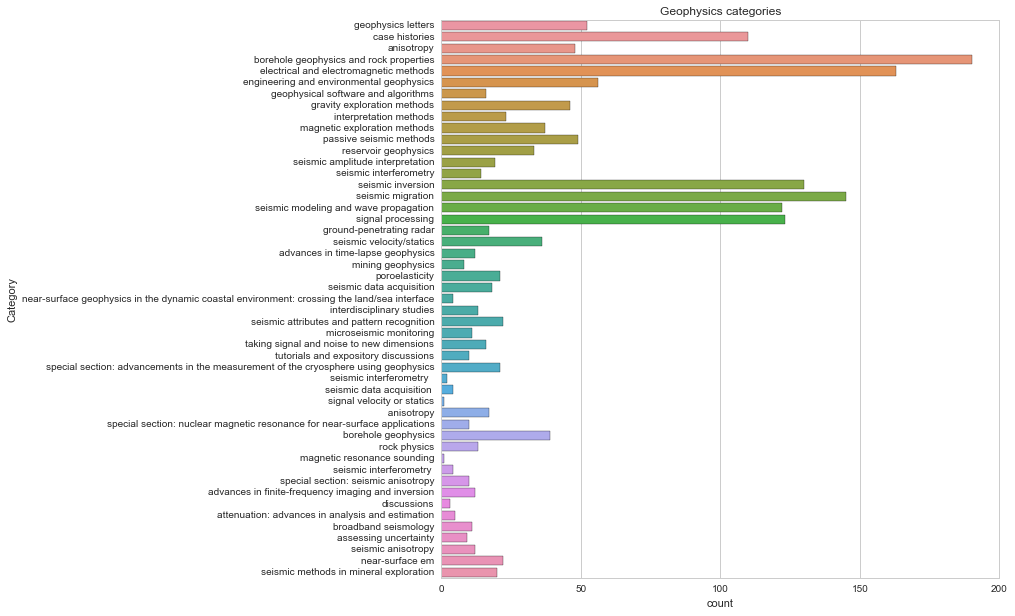

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.countplot(ax=ax, y="Category", data=df_seg)
ax.set_title('Geophysics categories')

Now I create a vector of titles and category to predict (one to start):

In [23]:
chosen_category='Category_borehole geophysics and rock properties'
#chosen_category='Category_Seismic Inversion'

# Create column with 1 and 0 for each category
df_seg_category = pd.get_dummies(df_seg,columns=['Category'])

X = df_seg_category['Title'].values
y = df_seg_category[chosen_category].values

As there are much more samples from the other categories I remove some of them to avoid overfitting  

In [24]:
#restrict number of elements in other categories
n_chosen_category = len(np.where(y==1)[0])
remove_elements = np.where(y==0)[0][:-n_chosen_category]

X = np.delete(X, remove_elements, axis=0)
y = np.delete(y, remove_elements, axis=0)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

print('Number of %s in train: %d' % ('Others', len(y_train) - y_train.sum()))
print('Number of %s in train: %d' % (chosen_category[9:], y_train.sum()))

print('Number of %s in test: %d'  % ('Others', len(y_test) - y_test.sum()))
print('Number of %s in test: %d'  % (chosen_category[9:], y_test.sum()))


count_vectorizer = CountVectorizer(stop_words='english')
count_train      = count_vectorizer.fit_transform(X_train)
count_test       = count_vectorizer.transform(X_test)

nb_classifier = MultinomialNB()
#nb_classifier = RandomForestClassifier()

nb_classifier.fit(count_train, y_train)

pred_train = nb_classifier.predict(count_train)
pred_test  = nb_classifier.predict(count_test)

Number of Others in train: 123
Number of borehole geophysics and rock properties in train: 131
Number of Others in test: 67
Number of borehole geophysics and rock properties in test: 59


I finally evaluate our classifier

In [26]:
print('Accuracy  (Train): %f'   % metrics.accuracy_score(y_train, pred_train))
print('Precision (Train): %f'   % metrics.precision_score(y_train, pred_train))
print('Recall    (Train): %f'   % metrics.recall_score(y_train, pred_train))

print metrics.classification_report(y_train, pred_train, labels=[1,0], target_names=[chosen_category[9:],'Other']) 

Accuracy  (Train): 0.956693
Precision (Train): 0.941176
Recall    (Train): 0.977099
                                         precision    recall  f1-score   support

borehole geophysics and rock properties       0.94      0.98      0.96       131
                                  Other       0.97      0.93      0.95       123

                            avg / total       0.96      0.96      0.96       254



In [27]:
print('Accuracy  (Test): %f'   % metrics.accuracy_score(y_test, pred_test))
print('Precision (Test): %f'   % metrics.precision_score(y_test, pred_test))
print('Recall    (Test): %f'   % metrics.recall_score(y_test, pred_test))

print metrics.classification_report(y_test, pred_test, labels=[1,0], target_names=[chosen_category[9:],'Other']) 

Accuracy  (Test): 0.801587
Precision (Test): 0.765625
Recall    (Test): 0.830508
                                         precision    recall  f1-score   support

borehole geophysics and rock properties       0.77      0.83      0.80        59
                                  Other       0.84      0.78      0.81        67

                            avg / total       0.80      0.80      0.80       126



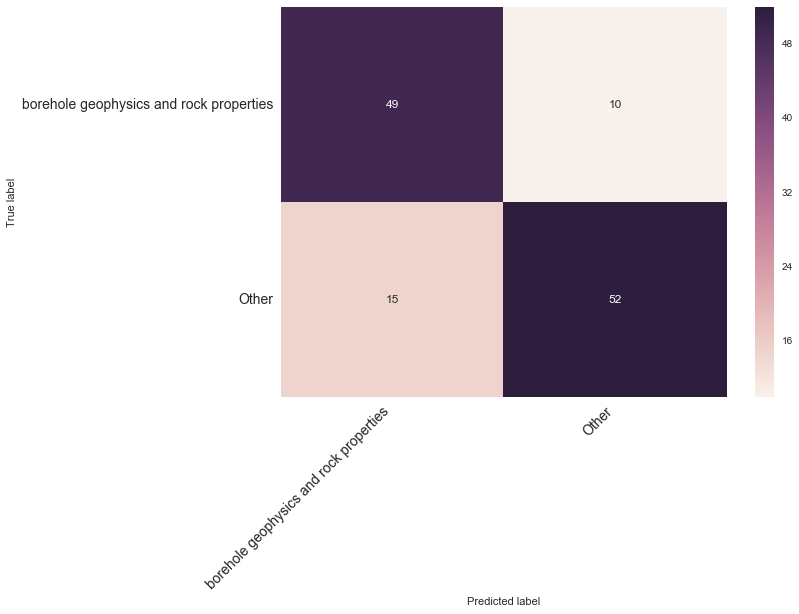

In [28]:
print_confusion_matrix(metrics.confusion_matrix(y_test, pred_test, labels=[1,0]),[chosen_category[9:],'Other'] )

## Future work

Much more can be done with this data and even better would be to be able to compare Geophysics with its European companion journal Geophysical Prospecting. Here are some ideas forth pursuing:

- Compare statistics of Geophysics and Geophysical Prospecting. Would the number of USA papers go down in a European Journal?